# Finetuning de modelos BERT para classificação de laudos médicos

## Exemplo de criação de dados sintéticos com Faker

In [14]:
import os
import requests
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from faker import Faker
import random

## Baixar dados

In [15]:
# Link para o dataset
url = "https://archive.ics.uci.edu/static/public/17/breast+cancer+wisconsin+diagnostic.zip"

# Pasta de destino onde o arquivo será descompactado
dest_folder = "../data"

# Arquivo zip de destino
dest_zip_file = os.path.join(dest_folder, "breast_cancer_wisconsin_diagnostic.zip")

# Arquivo parquet de destino
dest_parquet_file = os.path.join(dest_folder, "breast_cancer.parquet")

if not os.path.exists(dest_folder):

    # Crie a pasta se ela não existir
    print(f"Criando a pasta {dest_folder}...")
    os.makedirs(dest_folder, exist_ok=True)

    # Faça o download e salve o arquivo
    print("Baixando o dataset...")
    response = requests.get(url)
    response.raise_for_status()  # Levanta um erro se o download falhar

    with open(dest_zip_file, "wb") as f:
        f.write(response.content)
    print(f"Download concluído e salvo em {dest_zip_file}")

    # Descompacte o arquivo
    print("Descompactando o arquivo...")
    with zipfile.ZipFile(dest_zip_file, 'r') as zip_ref:
        zip_ref.extractall(dest_folder)

    print(f"Arquivos descompactados em {dest_folder}")
else:
    print(f"Os arquivos já existem em {dest_folder}")

Os arquivos já existem em ../data


## Ajustar colunas

In [16]:
# Caminho para os arquivos de dados e nomes
data_file = os.path.join(dest_folder, "wdbc.data")

# Carregar os dados
data = pd.read_csv(data_file, header=None, sep=",")

# 12 primeiras colunas
data = data.iloc[:, :12]

# Definir os nomes das colunas
column_names = [
    "id_number",
    "diagnosis",
    "radius",
    "texture",
    "perimeter",
    "area",
    "smoothness",
    "compactness",
    "concavity",
    "concave points",
    "symmetry",
    "fractal dimension"
]

# Definir os nomes das colunas no DataFrame
data.columns = column_names

# Exibir as primeiras linhas do DataFrame
data.head()

,id_number,diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concave points,symmetry,fractal dimension
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


## Distribuição de diagnósticos

In [17]:
# Mostrar informações sobre a coluna "diagnosis"
data["diagnosis"].value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

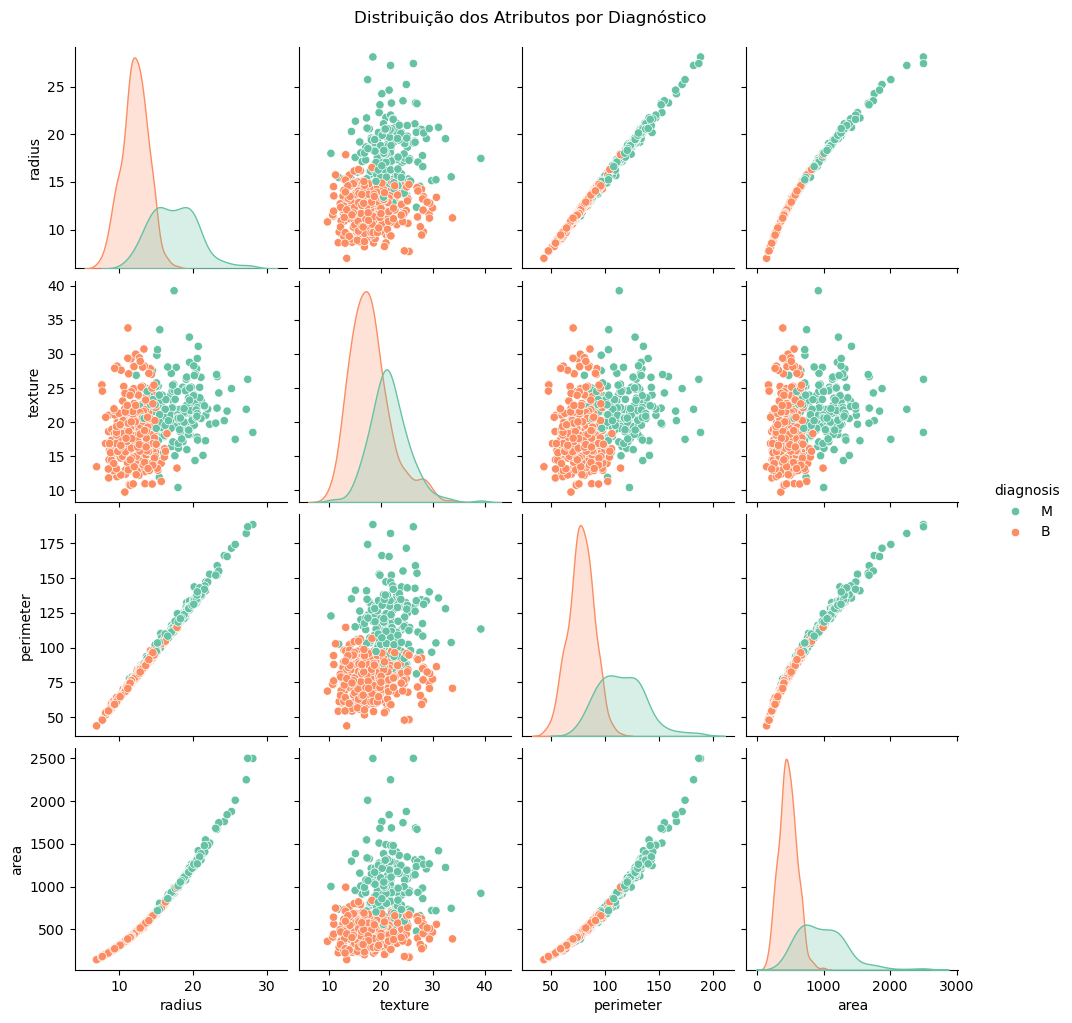

In [18]:
# Plotar a distribuição dos atributos por diagnóstico
sns.pairplot(data, hue='diagnosis', vars=['radius', 'texture', 'perimeter', 'area'], palette='Set2')
plt.suptitle("Distribuição dos Atributos por Diagnóstico", y=1.02)
plt.show()

## Gerar laudos baseado nos dados

In [19]:
fake = Faker('pt_BR')

# Função para traduzir o diagnóstico
def traduzir_diagnostico(diagnostico):
    return "Benigno" if diagnostico == "B" else "Maligno"

# Função para gerar laudo
def gerar_laudo(row):
    paciente = fake.name()
    tamanho = round(row['radius'] * 2, 1)
    textura = "regular" if row['texture'] < 20 else "irregular"
    quadrante = random.choice(["superior esquerdo", "superior direito", "inferior esquerdo", "inferior direito"])
    diagnostico = traduzir_diagnostico(row['diagnosis'])

    return f"""
        Paciente: {paciente}
        Exame: Mamografia
        Data do Exame: {fake.date_this_year()}

        Descrição:
        Observou-se uma lesão de aproximadamente {tamanho} mm, localizada no quadrante {quadrante}, com bordas {textura}.
        O exame sugere que a lesão apresenta características {diagnostico.lower()}.

        Conclusão: {diagnostico}.
        Recomendação: {('Acompanhar evolução com novo exame em 6 meses' if diagnostico == 'Benigno' else 'Encaminhar para biópsia e avaliação oncológica')}.
        """

# Aplicar em todas as linhas do dataset
data['laudo'] = data.apply(gerar_laudo, axis=1)

## Verificar laudos gerados

In [20]:
# Mostre apenas as colunas diagnosis e laudo
data[['id_number','diagnosis', 'laudo']].head()

,id_number,diagnosis,laudo
0,842302,M,\n Paciente: Milena Ramos\n Exam...
1,842517,M,\n Paciente: Nicolas Farias\n Ex...
2,84300903,M,\n Paciente: Mariana da Conceição\n ...
3,84348301,M,\n Paciente: Dra. Lívia Nunes\n ...
4,84358402,M,\n Paciente: Ana Clara Rezende\n ...


In [21]:
# Mostre o texto completo do laudo para os primeiros 3 diagnósticos malignos
for laudo in data[data['diagnosis'] == 'M']['laudo'].head(3):
    print(laudo)
    print("=" * 80)


        Paciente: Milena Ramos
        Exame: Mamografia
        Data do Exame: 2024-08-08

        Descrição:
        Observou-se uma lesão de aproximadamente 36.0 mm, localizada no quadrante superior esquerdo, com bordas regular.
        O exame sugere que a lesão apresenta características maligno.

        Conclusão: Maligno.
        Recomendação: Encaminhar para biópsia e avaliação oncológica.
        

        Paciente: Nicolas Farias
        Exame: Mamografia
        Data do Exame: 2024-01-16

        Descrição:
        Observou-se uma lesão de aproximadamente 41.1 mm, localizada no quadrante inferior direito, com bordas regular.
        O exame sugere que a lesão apresenta características maligno.

        Conclusão: Maligno.
        Recomendação: Encaminhar para biópsia e avaliação oncológica.
        

        Paciente: Mariana da Conceição
        Exame: Mamografia
        Data do Exame: 2024-08-17

        Descrição:
        Observou-se uma lesão de aproximadamente 39.4 mm,

In [22]:
# Mostre o texto completo do laudo para os primeiros 3 diagnósticos benignos
for laudo in data[data['diagnosis'] == 'B']['laudo'].head(3):
    print(laudo)
    print("=" * 80)


        Paciente: João Pedro Nunes
        Exame: Mamografia
        Data do Exame: 2024-03-14

        Descrição:
        Observou-se uma lesão de aproximadamente 27.1 mm, localizada no quadrante inferior direito, com bordas regular.
        O exame sugere que a lesão apresenta características benigno.

        Conclusão: Benigno.
        Recomendação: Acompanhar evolução com novo exame em 6 meses.
        

        Paciente: Amanda Camargo
        Exame: Mamografia
        Data do Exame: 2024-07-29

        Descrição:
        Observou-se uma lesão de aproximadamente 26.2 mm, localizada no quadrante superior esquerdo, com bordas regular.
        O exame sugere que a lesão apresenta características benigno.

        Conclusão: Benigno.
        Recomendação: Acompanhar evolução com novo exame em 6 meses.
        

        Paciente: Allana Aragão
        Exame: Mamografia
        Data do Exame: 2024-02-18

        Descrição:
        Observou-se uma lesão de aproximadamente 19.0 mm, loca

## Adicionar Ruido

In [23]:
# Introduzir ruído nos dados
def adicionar_ruido(row):

    # row['radius'] += random.uniform(-1, 1)  # Pequeno ajuste aleatório no raio
    # row['texture'] += random.uniform(-1, 1)  # Pequeno ajuste aleatório na textura

    if random.random() < 0.05:  # 5% de chance de alterar o diagnóstico
        row['diagnosis'] = "B" if row['diagnosis'] == "M" else "M"

    return row

data = data.apply(adicionar_ruido, axis=1)

## Salvar dados

In [24]:
# salvar dataframe em um arquivo parquet na pasta data
data.to_parquet(os.path.join(dest_folder, "breast_cancer.parquet"))